# Afriat

In [1]:
ood_seed = 6

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('2', 'Pericentral', 'Uninfected')


Removed datapoint: 587

train         14796
validation     3670
ood             587
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 50%|████▉     | 9516/19053 [00:00<00:00, 95154.65it/s]

100%|██████████| 19053/19053 [00:00<00:00, 96043.64it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1065009.78it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 420.55it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:04:55,  9.76s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:04:55,  9.76s/it, v_num=1, recon=3.97e+3, r2_mean=0.203, adv_loss=3.29, acc_pert=0.264, acc_zone=0.75, acc_status_control=0.48]

Epoch 2/400:   0%|          | 1/400 [00:09<1:04:55,  9.76s/it, v_num=1, recon=3.97e+3, r2_mean=0.203, adv_loss=3.29, acc_pert=0.264, acc_zone=0.75, acc_status_control=0.48]

Epoch 2/400:   0%|          | 2/400 [00:19<1:04:11,  9.68s/it, v_num=1, recon=3.97e+3, r2_mean=0.203, adv_loss=3.29, acc_pert=0.264, acc_zone=0.75, acc_status_control=0.48]

Epoch 2/400:   0%|          | 2/400 [00:19<1:04:11,  9.68s/it, v_num=1, recon=3.25e+3, r2_mean=0.614, adv_loss=2.86, acc_pert=0.392, acc_zone=0.83, acc_status_control=0.606]

Epoch 3/400:   0%|          | 2/400 [00:19<1:04:11,  9.68s/it, v_num=1, recon=3.25e+3, r2_mean=0.614, adv_loss=2.86, acc_pert=0.392, acc_zone=0.83, acc_status_control=0.606]

Epoch 3/400:   1%|          | 3/400 [00:28<1:03:38,  9.62s/it, v_num=1, recon=3.25e+3, r2_mean=0.614, adv_loss=2.86, acc_pert=0.392, acc_zone=0.83, acc_status_control=0.606]

Epoch 3/400:   1%|          | 3/400 [00:28<1:03:38,  9.62s/it, v_num=1, recon=3.19e+3, r2_mean=0.716, adv_loss=2.83, acc_pert=0.374, acc_zone=0.84, acc_status_control=0.606]

Epoch 4/400:   1%|          | 3/400 [00:28<1:03:38,  9.62s/it, v_num=1, recon=3.19e+3, r2_mean=0.716, adv_loss=2.83, acc_pert=0.374, acc_zone=0.84, acc_status_control=0.606]

Epoch 4/400:   1%|          | 4/400 [00:38<1:03:23,  9.61s/it, v_num=1, recon=3.19e+3, r2_mean=0.716, adv_loss=2.83, acc_pert=0.374, acc_zone=0.84, acc_status_control=0.606]

Epoch 4/400:   1%|          | 4/400 [00:38<1:03:23,  9.61s/it, v_num=1, recon=3.17e+3, r2_mean=0.752, adv_loss=2.76, acc_pert=0.41, acc_zone=0.843, acc_status_control=0.607]

Epoch 5/400:   1%|          | 4/400 [00:38<1:03:23,  9.61s/it, v_num=1, recon=3.17e+3, r2_mean=0.752, adv_loss=2.76, acc_pert=0.41, acc_zone=0.843, acc_status_control=0.607]

Epoch 5/400:   1%|▏         | 5/400 [00:48<1:03:07,  9.59s/it, v_num=1, recon=3.17e+3, r2_mean=0.752, adv_loss=2.76, acc_pert=0.41, acc_zone=0.843, acc_status_control=0.607]

Epoch 5/400:   1%|▏         | 5/400 [00:48<1:03:07,  9.59s/it, v_num=1, recon=3.16e+3, r2_mean=0.772, adv_loss=2.6, acc_pert=0.484, acc_zone=0.847, acc_status_control=0.609]

Epoch 6/400:   1%|▏         | 5/400 [00:48<1:03:07,  9.59s/it, v_num=1, recon=3.16e+3, r2_mean=0.772, adv_loss=2.6, acc_pert=0.484, acc_zone=0.847, acc_status_control=0.609]

Epoch 6/400:   2%|▏         | 6/400 [00:57<1:02:42,  9.55s/it, v_num=1, recon=3.16e+3, r2_mean=0.772, adv_loss=2.6, acc_pert=0.484, acc_zone=0.847, acc_status_control=0.609]

Epoch 6/400:   2%|▏         | 6/400 [00:57<1:02:42,  9.55s/it, v_num=1, recon=3.15e+3, r2_mean=0.787, adv_loss=2.44, acc_pert=0.531, acc_zone=0.851, acc_status_control=0.61]

Epoch 7/400:   2%|▏         | 6/400 [00:57<1:02:42,  9.55s/it, v_num=1, recon=3.15e+3, r2_mean=0.787, adv_loss=2.44, acc_pert=0.531, acc_zone=0.851, acc_status_control=0.61]

Epoch 7/400:   2%|▏         | 7/400 [01:07<1:02:34,  9.55s/it, v_num=1, recon=3.15e+3, r2_mean=0.787, adv_loss=2.44, acc_pert=0.531, acc_zone=0.851, acc_status_control=0.61]

Epoch 7/400:   2%|▏         | 7/400 [01:07<1:02:34,  9.55s/it, v_num=1, recon=3.14e+3, r2_mean=0.795, adv_loss=2.33, acc_pert=0.568, acc_zone=0.855, acc_status_control=0.615]

Epoch 8/400:   2%|▏         | 7/400 [01:07<1:02:34,  9.55s/it, v_num=1, recon=3.14e+3, r2_mean=0.795, adv_loss=2.33, acc_pert=0.568, acc_zone=0.855, acc_status_control=0.615]

Epoch 8/400:   2%|▏         | 8/400 [01:16<1:02:29,  9.56s/it, v_num=1, recon=3.14e+3, r2_mean=0.795, adv_loss=2.33, acc_pert=0.568, acc_zone=0.855, acc_status_control=0.615]

Epoch 8/400:   2%|▏         | 8/400 [01:16<1:02:29,  9.56s/it, v_num=1, recon=3.13e+3, r2_mean=0.806, adv_loss=2.26, acc_pert=0.584, acc_zone=0.86, acc_status_control=0.616] 

Epoch 9/400:   2%|▏         | 8/400 [01:16<1:02:29,  9.56s/it, v_num=1, recon=3.13e+3, r2_mean=0.806, adv_loss=2.26, acc_pert=0.584, acc_zone=0.86, acc_status_control=0.616]

Epoch 9/400:   2%|▏         | 9/400 [01:26<1:02:24,  9.58s/it, v_num=1, recon=3.13e+3, r2_mean=0.806, adv_loss=2.26, acc_pert=0.584, acc_zone=0.86, acc_status_control=0.616]

Epoch 9/400:   2%|▏         | 9/400 [01:26<1:02:24,  9.58s/it, v_num=1, recon=3.13e+3, r2_mean=0.808, adv_loss=2.2, acc_pert=0.613, acc_zone=0.863, acc_status_control=0.619]

Epoch 10/400:   2%|▏         | 9/400 [01:26<1:02:24,  9.58s/it, v_num=1, recon=3.13e+3, r2_mean=0.808, adv_loss=2.2, acc_pert=0.613, acc_zone=0.863, acc_status_control=0.619]


disnt_basal = 1.2399459512231972

disnt_after = 1.9101155500602136

val_r2_mean = 0.805651248958312

val_r2_var = 0.1878191525172352


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:41<1:12:52, 11.21s/it, v_num=1, recon=3.13e+3, r2_mean=0.808, adv_loss=2.2, acc_pert=0.613, acc_zone=0.863, acc_status_control=0.619]

Epoch 10/400:   2%|▎         | 10/400 [01:41<1:12:52, 11.21s/it, v_num=1, recon=3.12e+3, r2_mean=0.81, adv_loss=2.19, acc_pert=0.612, acc_zone=0.861, acc_status_control=0.615, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:41<1:12:52, 11.21s/it, v_num=1, recon=3.12e+3, r2_mean=0.81, adv_loss=2.19, acc_pert=0.612, acc_zone=0.861, acc_status_control=0.615, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:50<1:09:06, 10.66s/it, v_num=1, recon=3.12e+3, r2_mean=0.81, adv_loss=2.19, acc_pert=0.612, acc_zone=0.861, acc_status_control=0.615, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:50<1:09:06, 10.66s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=2.15, acc_pert=0.635, acc_zone=0.857, acc_status_control=0.618, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:50<1:09:06, 10.66s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=2.15, acc_pert=0.635, acc_zone=0.857, acc_status_control=0.618, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:59<1:06:26, 10.27s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=2.15, acc_pert=0.635, acc_zone=0.857, acc_status_control=0.618, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:59<1:06:26, 10.27s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=2.11, acc_pert=0.641, acc_zone=0.863, acc_status_control=0.621, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:59<1:06:26, 10.27s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=2.11, acc_pert=0.641, acc_zone=0.863, acc_status_control=0.621, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:09<1:04:34, 10.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=2.11, acc_pert=0.641, acc_zone=0.863, acc_status_control=0.621, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:09<1:04:34, 10.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.09, acc_pert=0.65, acc_zone=0.862, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [02:09<1:04:34, 10.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.09, acc_pert=0.65, acc_zone=0.862, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:18<1:03:13,  9.83s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.09, acc_pert=0.65, acc_zone=0.862, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:18<1:03:13,  9.83s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=2.09, acc_pert=0.643, acc_zone=0.863, acc_status_control=0.625, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:18<1:03:13,  9.83s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=2.09, acc_pert=0.643, acc_zone=0.863, acc_status_control=0.625, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:28<1:02:15,  9.70s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=2.09, acc_pert=0.643, acc_zone=0.863, acc_status_control=0.625, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:28<1:02:15,  9.70s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=2.12, acc_pert=0.644, acc_zone=0.859, acc_status_control=0.628, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:28<1:02:15,  9.70s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=2.12, acc_pert=0.644, acc_zone=0.859, acc_status_control=0.628, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:37<1:01:26,  9.60s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=2.12, acc_pert=0.644, acc_zone=0.859, acc_status_control=0.628, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:37<1:01:26,  9.60s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.09, acc_pert=0.65, acc_zone=0.854, acc_status_control=0.629, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:37<1:01:26,  9.60s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.09, acc_pert=0.65, acc_zone=0.854, acc_status_control=0.629, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:46<1:00:59,  9.55s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.09, acc_pert=0.65, acc_zone=0.854, acc_status_control=0.629, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:47<1:00:59,  9.55s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.07, acc_pert=0.654, acc_zone=0.858, acc_status_control=0.631, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:47<1:00:59,  9.55s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.07, acc_pert=0.654, acc_zone=0.858, acc_status_control=0.631, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:56<1:00:36,  9.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.07, acc_pert=0.654, acc_zone=0.858, acc_status_control=0.631, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:56<1:00:36,  9.52s/it, v_num=1, recon=3.08e+3, r2_mean=0.826, adv_loss=2.07, acc_pert=0.651, acc_zone=0.858, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:56<1:00:36,  9.52s/it, v_num=1, recon=3.08e+3, r2_mean=0.826, adv_loss=2.07, acc_pert=0.651, acc_zone=0.858, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:05<1:00:17,  9.50s/it, v_num=1, recon=3.08e+3, r2_mean=0.826, adv_loss=2.07, acc_pert=0.651, acc_zone=0.858, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:05<1:00:17,  9.50s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.1, acc_pert=0.644, acc_zone=0.858, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan] 

Epoch 20/400:   5%|▍         | 19/400 [03:05<1:00:17,  9.50s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.1, acc_pert=0.644, acc_zone=0.858, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]


disnt_basal = 1.233382599157354

disnt_after = 1.888159244116345

val_r2_mean = 0.8150330611654615

val_r2_var = 0.22179853400246685

Epoch 20/400:   5%|▌         | 20/400 [03:20<1:09:59, 11.05s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.1, acc_pert=0.644, acc_zone=0.858, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:20<1:09:59, 11.05s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.13, acc_pert=0.634, acc_zone=0.858, acc_status_control=0.627, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [03:20<1:09:59, 11.05s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.13, acc_pert=0.634, acc_zone=0.858, acc_status_control=0.627, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:29<1:06:40, 10.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.13, acc_pert=0.634, acc_zone=0.858, acc_status_control=0.627, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:29<1:06:40, 10.56s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=2.13, acc_pert=0.628, acc_zone=0.86, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [03:29<1:06:40, 10.56s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=2.13, acc_pert=0.628, acc_zone=0.86, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:39<1:04:15, 10.20s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=2.13, acc_pert=0.628, acc_zone=0.86, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:39<1:04:15, 10.20s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.63, acc_zone=0.86, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [03:39<1:04:15, 10.20s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.63, acc_zone=0.86, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:48<1:02:26,  9.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.63, acc_zone=0.86, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:48<1:02:26,  9.94s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.14, acc_pert=0.623, acc_zone=0.861, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:48<1:02:26,  9.94s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.14, acc_pert=0.623, acc_zone=0.861, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:58<1:01:26,  9.81s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.14, acc_pert=0.623, acc_zone=0.861, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:58<1:01:26,  9.81s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.14, acc_pert=0.622, acc_zone=0.862, acc_status_control=0.63, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [03:58<1:01:26,  9.81s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.14, acc_pert=0.622, acc_zone=0.862, acc_status_control=0.63, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:07<1:00:41,  9.71s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.14, acc_pert=0.622, acc_zone=0.862, acc_status_control=0.63, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:07<1:00:41,  9.71s/it, v_num=1, recon=3.06e+3, r2_mean=0.824, adv_loss=2.14, acc_pert=0.618, acc_zone=0.858, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [04:07<1:00:41,  9.71s/it, v_num=1, recon=3.06e+3, r2_mean=0.824, adv_loss=2.14, acc_pert=0.618, acc_zone=0.858, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:17<1:00:03,  9.64s/it, v_num=1, recon=3.06e+3, r2_mean=0.824, adv_loss=2.14, acc_pert=0.618, acc_zone=0.858, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:17<1:00:03,  9.64s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.12, acc_pert=0.616, acc_zone=0.858, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [04:17<1:00:03,  9.64s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.12, acc_pert=0.616, acc_zone=0.858, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:26<59:32,  9.58s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.12, acc_pert=0.616, acc_zone=0.858, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]  

Epoch 27/400:   7%|▋         | 27/400 [04:26<59:32,  9.58s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.623, acc_zone=0.858, acc_status_control=0.64, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [04:26<59:32,  9.58s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.623, acc_zone=0.858, acc_status_control=0.64, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:36<59:10,  9.54s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.623, acc_zone=0.858, acc_status_control=0.64, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:36<59:10,  9.54s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.13, acc_pert=0.618, acc_zone=0.856, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:36<59:10,  9.54s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.13, acc_pert=0.618, acc_zone=0.856, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:45<58:56,  9.53s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.13, acc_pert=0.618, acc_zone=0.856, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:45<58:56,  9.53s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=2.14, acc_pert=0.616, acc_zone=0.857, acc_status_control=0.637, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [04:45<58:56,  9.53s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=2.14, acc_pert=0.616, acc_zone=0.857, acc_status_control=0.637, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]


disnt_basal = 1.2229288581663744

disnt_after = 1.8761556114002549

val_r2_mean = 0.8255218798437114

val_r2_var = 0.24392821330337774


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [05:00<1:08:01, 11.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=2.14, acc_pert=0.616, acc_zone=0.857, acc_status_control=0.637, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.815, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [05:00<1:08:01, 11.03s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.621, acc_zone=0.857, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [05:00<1:08:01, 11.03s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.621, acc_zone=0.857, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:09<1:05:00, 10.57s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.621, acc_zone=0.857, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:09<1:05:00, 10.57s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.15, acc_pert=0.61, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [05:09<1:05:00, 10.57s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.15, acc_pert=0.61, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:19<1:03:02, 10.28s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.15, acc_pert=0.61, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:19<1:03:02, 10.28s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.14, acc_pert=0.616, acc_zone=0.856, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [05:19<1:03:02, 10.28s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.14, acc_pert=0.616, acc_zone=0.856, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:28<1:01:24, 10.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.14, acc_pert=0.616, acc_zone=0.856, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:28<1:01:24, 10.04s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.13, acc_pert=0.62, acc_zone=0.856, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [05:28<1:01:24, 10.04s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.13, acc_pert=0.62, acc_zone=0.856, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:38<1:00:08,  9.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.13, acc_pert=0.62, acc_zone=0.856, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:38<1:00:08,  9.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.859, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:38<1:00:08,  9.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.859, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:47<59:18,  9.75s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.859, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]  

Epoch 35/400:   9%|▉         | 35/400 [05:47<59:18,  9.75s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:47<59:18,  9.75s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:56<58:30,  9.64s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:56<58:30,  9.64s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.612, acc_zone=0.855, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:56<58:30,  9.64s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.612, acc_zone=0.855, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:06<57:55,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.612, acc_zone=0.855, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:06<57:55,  9.58s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.612, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [06:06<57:55,  9.58s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.612, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:15<57:26,  9.52s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.612, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:15<57:26,  9.52s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.602, acc_zone=0.854, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [06:15<57:26,  9.52s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.602, acc_zone=0.854, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:25<57:16,  9.52s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.602, acc_zone=0.854, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:25<57:16,  9.52s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.603, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [06:25<57:16,  9.52s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.603, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2212642041431188

disnt_after = 1.882807757379259

val_r2_mean = 0.8287980137642639

val_r2_var = 0.24855167631699385


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:39<1:05:51, 10.98s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.603, acc_zone=0.854, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:39<1:05:51, 10.98s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.617, acc_zone=0.853, acc_status_control=0.652, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:39<1:05:51, 10.98s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.617, acc_zone=0.853, acc_status_control=0.652, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:49<1:02:58, 10.53s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.617, acc_zone=0.853, acc_status_control=0.652, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:49<1:02:58, 10.53s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [06:49<1:02:58, 10.53s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:58<1:01:01, 10.23s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:58<1:01:01, 10.23s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.855, acc_status_control=0.649, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:58<1:01:01, 10.23s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.855, acc_status_control=0.649, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [07:08<59:27,  9.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.603, acc_zone=0.855, acc_status_control=0.649, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]  

Epoch 43/400:  11%|█         | 43/400 [07:08<59:27,  9.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [07:08<59:27,  9.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:17<58:24,  9.84s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:17<58:24,  9.84s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.603, acc_zone=0.852, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [07:17<58:24,  9.84s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.603, acc_zone=0.852, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:27<57:35,  9.73s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.603, acc_zone=0.852, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:27<57:35,  9.73s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.15, acc_pert=0.604, acc_zone=0.855, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]    

Epoch 46/400:  11%|█▏        | 45/400 [07:27<57:35,  9.73s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.15, acc_pert=0.604, acc_zone=0.855, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:36<56:57,  9.65s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.15, acc_pert=0.604, acc_zone=0.855, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:36<56:57,  9.65s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.598, acc_zone=0.851, acc_status_control=0.655, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [07:36<56:57,  9.65s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.598, acc_zone=0.851, acc_status_control=0.655, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:45<56:27,  9.60s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.598, acc_zone=0.851, acc_status_control=0.655, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:45<56:27,  9.60s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.652, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]  

Epoch 48/400:  12%|█▏        | 47/400 [07:46<56:27,  9.60s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.652, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:55<56:14,  9.59s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.652, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:55<56:14,  9.59s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.598, acc_zone=0.855, acc_status_control=0.65, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:55<56:14,  9.59s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.598, acc_zone=0.855, acc_status_control=0.65, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [08:05<55:54,  9.56s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.598, acc_zone=0.855, acc_status_control=0.65, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [08:05<55:54,  9.56s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.605, acc_zone=0.85, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [08:05<55:54,  9.56s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.605, acc_zone=0.85, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2189330292262601

disnt_after = 1.8802293978606623

val_r2_mean = 0.8304886267129838

val_r2_var = 0.25838225927373837


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [08:19<1:04:02, 10.98s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.605, acc_zone=0.85, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [08:19<1:04:02, 10.98s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.586, acc_zone=0.852, acc_status_control=0.654, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [08:19<1:04:02, 10.98s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.586, acc_zone=0.852, acc_status_control=0.654, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:28<1:01:13, 10.52s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.586, acc_zone=0.852, acc_status_control=0.654, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:28<1:01:13, 10.52s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [08:28<1:01:13, 10.52s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:38<59:19, 10.23s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 52/400:  13%|█▎        | 52/400 [08:38<59:19, 10.23s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.585, acc_zone=0.848, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [08:38<59:19, 10.23s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.585, acc_zone=0.848, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:47<57:43,  9.98s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.585, acc_zone=0.848, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:47<57:43,  9.98s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.59, acc_zone=0.851, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [08:47<57:43,  9.98s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.59, acc_zone=0.851, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:57<57:19,  9.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.59, acc_zone=0.851, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:57<57:19,  9.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.585, acc_zone=0.849, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:57<57:19,  9.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.585, acc_zone=0.849, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:07<56:22,  9.80s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.585, acc_zone=0.849, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:07<56:22,  9.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [09:07<56:22,  9.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:16<55:45,  9.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:16<55:45,  9.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.584, acc_zone=0.853, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [09:16<55:45,  9.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.584, acc_zone=0.853, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:26<55:16,  9.67s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.584, acc_zone=0.853, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:26<55:16,  9.67s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.576, acc_zone=0.85, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [09:26<55:16,  9.67s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.576, acc_zone=0.85, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:35<54:51,  9.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.576, acc_zone=0.85, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:35<54:51,  9.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [09:35<54:51,  9.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:45<54:28,  9.58s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:45<54:28,  9.58s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.584, acc_zone=0.846, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:45<54:28,  9.58s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.584, acc_zone=0.846, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2090137194348245

disnt_after = 1.878706347016864

val_r2_mean = 0.8246189541664143

val_r2_var = 0.26093099072040826


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:59<1:02:53, 11.10s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.584, acc_zone=0.846, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:59<1:02:53, 11.10s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:59<1:02:53, 11.10s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [10:09<59:58, 10.61s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 61/400 [10:09<59:58, 10.61s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [10:09<59:58, 10.61s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:18<57:53, 10.28s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:18<57:53, 10.28s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [10:18<57:53, 10.28s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:28<56:27, 10.05s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:28<56:27, 10.05s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [10:28<56:27, 10.05s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:37<55:28,  9.91s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:37<55:28,  9.91s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.584, acc_zone=0.848, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [10:37<55:28,  9.91s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.584, acc_zone=0.848, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:47<54:36,  9.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.584, acc_zone=0.848, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:47<54:36,  9.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.588, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [10:47<54:36,  9.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.588, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:56<53:57,  9.69s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.588, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:56<53:57,  9.69s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.58, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:56<53:57,  9.69s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.58, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [11:06<53:27,  9.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.58, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [11:06<53:27,  9.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [11:06<53:27,  9.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:15<53:08,  9.60s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:15<53:08,  9.60s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.572, acc_zone=0.846, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [11:15<53:08,  9.60s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.572, acc_zone=0.846, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:25<52:52,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.572, acc_zone=0.846, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:25<52:52,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [11:25<52:52,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.207766543215925

disnt_after = 1.879097614881083

val_r2_mean = 0.8274878744863178

val_r2_var = 0.26777493115133383


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [11:40<1:01:11, 11.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [11:40<1:01:11, 11.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [11:40<1:01:11, 11.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:49<58:14, 10.62s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 71/400:  18%|█▊        | 71/400 [11:49<58:14, 10.62s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [11:49<58:14, 10.62s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:58<56:03, 10.25s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:58<56:03, 10.25s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:58<56:03, 10.25s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:08<54:32, 10.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:08<54:32, 10.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.573, acc_zone=0.847, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [12:08<54:32, 10.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.573, acc_zone=0.847, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:17<53:28,  9.84s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.573, acc_zone=0.847, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:17<53:28,  9.84s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [12:17<53:28,  9.84s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:27<52:38,  9.72s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:27<52:38,  9.72s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [12:27<52:38,  9.72s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:36<52:09,  9.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:36<52:09,  9.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [12:36<52:09,  9.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:46<51:49,  9.63s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:46<51:49,  9.63s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [12:46<51:49,  9.63s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:55<51:33,  9.61s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:55<51:33,  9.61s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [12:55<51:33,  9.61s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [13:05<51:16,  9.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [13:05<51:16,  9.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [13:05<51:16,  9.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2009528805684297

disnt_after = 1.8815609157162474

val_r2_mean = 0.8232952197675694

val_r2_var = 0.26543740001180594


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [13:20<59:11, 11.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [13:20<59:11, 11.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [13:20<59:11, 11.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:29<56:23, 10.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:29<56:23, 10.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [13:29<56:23, 10.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:39<54:24, 10.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:39<54:24, 10.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [13:39<54:24, 10.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:48<52:52, 10.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:48<52:52, 10.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [13:48<52:52, 10.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:57<51:49,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:57<51:49,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [13:57<51:49,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [14:07<51:08,  9.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [14:07<51:08,  9.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]  

Epoch 86/400:  21%|██▏       | 85/400 [14:07<51:08,  9.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:16<50:37,  9.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:16<50:37,  9.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [14:16<50:37,  9.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:26<50:21,  9.65s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:26<50:21,  9.65s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [14:26<50:21,  9.65s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:35<49:57,  9.61s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:35<49:57,  9.61s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [14:36<49:57,  9.61s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:45<49:39,  9.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:45<49:39,  9.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [14:45<49:39,  9.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.1980380037235856

disnt_after = 1.8753855782806563

val_r2_mean = 0.8312152915249943

val_r2_var = 0.2862550430500115


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [15:00<57:33, 11.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.823, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [15:00<57:33, 11.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [15:00<57:33, 11.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [15:09<55:06, 10.70s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [15:09<55:06, 10.70s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [15:09<55:06, 10.70s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:19<53:14, 10.37s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:19<53:14, 10.37s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [15:19<53:14, 10.37s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:29<51:49, 10.13s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:29<51:49, 10.13s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [15:29<51:49, 10.13s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:38<50:44,  9.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:38<50:44,  9.95s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [15:38<50:44,  9.95s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:48<49:51,  9.81s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:48<49:51,  9.81s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [15:48<49:51,  9.81s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:57<49:14,  9.72s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:57<49:14,  9.72s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [15:57<49:14,  9.72s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [16:07<48:41,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [16:07<48:41,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [16:07<48:41,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:16<48:37,  9.66s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:16<48:37,  9.66s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [16:16<48:37,  9.66s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:26<48:10,  9.60s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:26<48:10,  9.60s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 100/400:  25%|██▍       | 99/400 [16:26<48:10,  9.60s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1950834744229595

disnt_after = 1.8789126842330386

val_r2_mean = 0.8316230230762609

val_r2_var = 0.2780696318098463


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [16:41<56:02, 11.21s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [16:41<56:02, 11.21s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [16:41<56:02, 11.21s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:50<53:11, 10.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:50<53:11, 10.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.644, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [16:50<53:11, 10.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.644, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [17:00<51:16, 10.32s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.644, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [17:00<51:16, 10.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [17:00<51:16, 10.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [17:09<49:51, 10.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [17:09<49:51, 10.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.26, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [17:09<49:51, 10.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.26, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:19<48:54,  9.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.26, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:19<48:54,  9.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [17:19<48:54,  9.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:28<48:00,  9.76s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:28<48:00,  9.76s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [17:28<48:00,  9.76s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:38<47:18,  9.65s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:38<47:18,  9.65s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [17:38<47:18,  9.65s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:47<46:52,  9.60s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.645, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:47<46:52,  9.60s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [17:47<46:52,  9.60s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:56<46:30,  9.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:56<46:30,  9.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.644, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]  

Epoch 109/400:  27%|██▋       | 108/400 [17:56<46:30,  9.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.644, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [18:06<46:11,  9.52s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.644, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [18:06<46:11,  9.52s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [18:06<46:11,  9.52s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1898903641133176

disnt_after = 1.881311451725678

val_r2_mean = 0.8251824886695174

val_r2_var = 0.2847843187661454


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [18:21<53:44, 11.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [18:21<53:44, 11.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.645, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [18:21<53:44, 11.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.645, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:30<51:22, 10.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.645, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:30<51:22, 10.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan] 

Epoch 112/400:  28%|██▊       | 111/400 [18:30<51:22, 10.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:40<49:23, 10.29s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:40<49:23, 10.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [18:40<49:23, 10.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:49<48:00, 10.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:49<48:00, 10.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.651, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [18:49<48:00, 10.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.651, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:59<47:05,  9.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.651, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:59<47:05,  9.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [18:59<47:05,  9.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [19:08<46:22,  9.76s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [19:08<46:22,  9.76s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan] 

Epoch 116/400:  29%|██▉       | 115/400 [19:08<46:22,  9.76s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:18<46:00,  9.72s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:18<46:00,  9.72s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [19:18<46:00,  9.72s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:27<45:36,  9.67s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:27<45:36,  9.67s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [19:27<45:36,  9.67s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:37<45:07,  9.60s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:37<45:07,  9.60s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [19:37<45:07,  9.60s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:46<44:45,  9.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:46<44:45,  9.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [19:46<44:45,  9.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1901386403277416

disnt_after = 1.8659635121732363

val_r2_mean = 0.8309608424989096

val_r2_var = 0.28735523781637284

Epoch 120/400:  30%|███       | 120/400 [20:01<52:30, 11.25s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.825, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [20:01<52:30, 11.25s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [20:01<52:30, 11.25s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [20:11<49:57, 10.74s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.649, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [20:11<49:57, 10.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.645, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [20:11<49:57, 10.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.645, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:20<47:58, 10.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.645, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:20<47:58, 10.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [20:20<47:58, 10.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:30<46:40, 10.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:30<46:40, 10.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.653, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [20:30<46:40, 10.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.653, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:40<45:47,  9.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.653, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:40<45:47,  9.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [20:40<45:47,  9.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:49<45:04,  9.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:49<45:04,  9.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [20:49<45:04,  9.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:59<44:23,  9.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.648, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:59<44:23,  9.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.652, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [20:59<44:23,  9.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.652, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [21:08<44:00,  9.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.652, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [21:08<44:00,  9.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [21:08<44:00,  9.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:18<43:33,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:18<43:33,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.65, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [21:18<43:33,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.65, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:27<43:40,  9.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.65, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:27<43:40,  9.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [21:27<43:40,  9.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.192745456458947

disnt_after = 1.873387919869932

val_r2_mean = 0.8318038783515767

val_r2_var = 0.2879564736391146

Epoch 130/400:  32%|███▎      | 130/400 [21:42<50:34, 11.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.646, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [21:42<50:34, 11.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]  

Epoch 131/400:  32%|███▎      | 130/400 [21:42<50:34, 11.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:52<48:03, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:52<48:03, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [21:52<48:03, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [22:01<46:14, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [22:01<46:14, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [22:01<46:14, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [22:11<45:00, 10.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [22:11<45:00, 10.11s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [22:11<45:00, 10.11s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:20<44:00,  9.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:20<44:00,  9.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [22:20<44:00,  9.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:30<43:19,  9.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:30<43:19,  9.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]  

Epoch 136/400:  34%|███▍      | 135/400 [22:30<43:19,  9.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:39<42:48,  9.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:39<42:48,  9.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [22:39<42:48,  9.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:49<42:26,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:49<42:26,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [22:49<42:26,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:59<42:04,  9.63s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:59<42:04,  9.63s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [22:59<42:04,  9.63s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [23:08<41:48,  9.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [23:08<41:48,  9.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [23:08<41:48,  9.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1825506869690305

disnt_after = 1.8729370221164823

val_r2_mean = 0.8273724338474469

val_r2_var = 0.27856030617361754

Epoch 140/400:  35%|███▌      | 140/400 [23:23<48:12, 11.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [23:23<48:12, 11.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [23:23<48:12, 11.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:32<45:50, 10.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:32<45:50, 10.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [23:32<45:50, 10.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:42<44:14, 10.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:42<44:14, 10.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.65, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [23:42<44:14, 10.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.65, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:51<43:00, 10.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.65, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:51<43:00, 10.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [23:51<43:00, 10.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [24:01<42:07,  9.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [24:01<42:07,  9.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [24:01<42:07,  9.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [24:10<41:32,  9.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [24:10<41:32,  9.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [24:10<41:32,  9.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [24:20<41:06,  9.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [24:20<41:06,  9.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [24:20<41:06,  9.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:29<40:39,  9.64s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:29<40:39,  9.64s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [24:29<40:39,  9.64s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:39<40:18,  9.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:39<40:18,  9.60s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [24:39<40:18,  9.60s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:48<40:07,  9.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:48<40:07,  9.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [24:48<40:07,  9.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1831469815166595

disnt_after = 1.873408518865533

val_r2_mean = 0.8252898153913278

val_r2_var = 0.2865773773099163

Epoch 150/400:  38%|███▊      | 150/400 [25:03<46:44, 11.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.651, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [25:03<46:44, 11.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.842, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [25:03<46:44, 11.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.842, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [25:13<44:23, 10.70s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.842, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [25:13<44:23, 10.70s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 152/400:  38%|███▊      | 151/400 [25:13<44:23, 10.70s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [25:22<42:42, 10.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.649, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [25:22<42:42, 10.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [25:22<42:42, 10.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:32<41:34, 10.10s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.646, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:32<41:34, 10.10s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.547, acc_zone=0.843, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [25:32<41:34, 10.10s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.547, acc_zone=0.843, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:41<40:37,  9.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.547, acc_zone=0.843, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:41<40:37,  9.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [25:41<40:37,  9.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:51<40:00,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:51<40:00,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.652, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [25:51<40:00,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.652, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [26:00<39:22,  9.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.652, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [26:00<39:22,  9.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [26:00<39:22,  9.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [26:10<39:09,  9.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.647, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [26:10<39:09,  9.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [26:10<39:09,  9.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [26:20<38:54,  9.65s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [26:20<38:54,  9.65s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [26:20<38:54,  9.65s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:29<38:49,  9.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.648, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:29<38:49,  9.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [26:29<38:49,  9.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1769006341841122

disnt_after = 1.8758121810704034

val_r2_mean = 0.8313637668885275

val_r2_var = 0.28796597614201264


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [26:44<44:29, 11.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.653, val_recon=2.9e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [26:44<44:29, 11.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [26:44<44:29, 11.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:53<42:26, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:53<42:26, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 162/400:  40%|████      | 161/400 [26:53<42:26, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [27:03<40:49, 10.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [27:03<40:49, 10.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [27:03<40:49, 10.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [27:12<39:39, 10.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [27:12<39:39, 10.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [27:12<39:39, 10.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [27:22<38:53,  9.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [27:22<38:53,  9.89s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [27:22<38:53,  9.89s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:31<38:09,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:31<38:09,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 166/400:  41%|████▏     | 165/400 [27:31<38:09,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:41<37:40,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:41<37:40,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [27:41<37:40,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:50<37:16,  9.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:50<37:16,  9.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [27:50<37:16,  9.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [28:00<36:56,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [28:00<36:56,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [28:00<36:56,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [28:09<36:38,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [28:09<36:38,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [28:09<36:38,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1750707925206503

disnt_after = 1.865754933457656

val_r2_mean = 0.8327859420078657

val_r2_var = 0.28829082298807385

Epoch 170/400:  42%|████▎     | 170/400 [28:23<42:01, 10.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [28:23<42:01, 10.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]  

Epoch 171/400:  42%|████▎     | 170/400 [28:23<42:01, 10.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:33<40:07, 10.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:33<40:07, 10.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [28:33<40:07, 10.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:42<38:47, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:42<38:47, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [28:42<38:47, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:52<37:55, 10.02s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:52<37:55, 10.02s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [28:52<37:55, 10.02s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [29:01<37:07,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [29:01<37:07,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.549, acc_zone=0.844, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [29:01<37:07,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.549, acc_zone=0.844, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [29:11<36:37,  9.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.549, acc_zone=0.844, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [29:11<36:37,  9.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]  

Epoch 176/400:  44%|████▍     | 175/400 [29:11<36:37,  9.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [29:20<36:13,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [29:20<36:13,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [29:20<36:13,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [29:30<36:04,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [29:30<36:04,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [29:30<36:04,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:40<35:40,  9.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:40<35:40,  9.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [29:40<35:40,  9.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:49<35:23,  9.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:49<35:23,  9.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [29:49<35:23,  9.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1716820382631408

disnt_after = 1.8665959216205383

val_r2_mean = 0.8324239519638694

val_r2_var = 0.290280759737289

Epoch 180/400:  45%|████▌     | 180/400 [30:04<40:39, 11.09s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [30:04<40:39, 11.09s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [30:04<40:39, 11.09s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [30:13<38:43, 10.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [30:13<38:43, 10.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [30:13<38:43, 10.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [30:23<37:21, 10.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [30:23<37:21, 10.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [30:23<37:21, 10.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:32<36:24, 10.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.65, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:32<36:24, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [30:32<36:24, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:42<35:37,  9.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:42<35:37,  9.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [30:42<35:37,  9.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:51<34:58,  9.76s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:51<34:58,  9.76s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [30:51<34:58,  9.76s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [31:01<34:36,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [31:01<34:36,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [31:01<34:36,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [31:10<34:13,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [31:10<34:13,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [31:10<34:13,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [31:20<33:56,  9.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [31:20<33:56,  9.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [31:20<33:56,  9.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [31:29<33:44,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [31:29<33:44,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [31:29<33:44,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1787663829860406

disnt_after = 1.8650986101649394

val_r2_mean = 0.8263513127857792

val_r2_var = 0.2911663488540697

Epoch 190/400:  48%|████▊     | 190/400 [31:44<39:13, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [31:44<39:13, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [31:44<39:13, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:54<37:15, 10.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:54<37:15, 10.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [31:54<37:15, 10.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [32:03<35:52, 10.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [32:03<35:52, 10.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [32:03<35:52, 10.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [32:13<34:48, 10.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [32:13<34:48, 10.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [32:13<34:48, 10.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [32:22<33:58,  9.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [32:22<33:58,  9.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [32:22<33:58,  9.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [32:32<33:18,  9.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [32:32<33:18,  9.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [32:32<33:18,  9.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:41<32:49,  9.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:41<32:49,  9.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.846, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [32:41<32:49,  9.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.846, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:51<32:27,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.846, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:51<32:27,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.547, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [32:51<32:27,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.547, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [33:00<32:11,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.547, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [33:00<32:11,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [33:00<32:11,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [33:10<31:59,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [33:10<31:59,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [33:10<31:59,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1781609164740128

disnt_after = 1.8524558683013288

val_r2_mean = 0.8249221958103687

val_r2_var = 0.2922824023776569

Epoch 200/400:  50%|█████     | 200/400 [33:24<36:57, 11.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.826, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [33:24<36:57, 11.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [33:24<36:57, 11.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [33:34<35:13, 10.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [33:34<35:13, 10.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [33:34<35:13, 10.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:43<33:55, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:43<33:55, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.547, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [33:43<33:55, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.547, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:53<32:54, 10.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.547, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:53<32:54, 10.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [33:53<32:54, 10.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [34:02<32:10,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [34:02<32:10,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [34:02<32:10,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [34:12<31:40,  9.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [34:12<31:40,  9.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.554, acc_zone=0.847, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [34:12<31:40,  9.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.554, acc_zone=0.847, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [34:21<31:18,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.554, acc_zone=0.847, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [34:21<31:18,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [34:21<31:18,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [34:31<31:00,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [34:31<31:00,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [34:31<31:00,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:40<30:46,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:40<30:46,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [34:40<30:46,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:50<30:23,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:50<30:23,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.545, acc_zone=0.841, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [34:50<30:23,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.545, acc_zone=0.841, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1674577465785974

disnt_after = 1.8680552493577804

val_r2_mean = 0.8267032578286843

val_r2_var = 0.2920559353342409


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [35:05<35:36, 11.24s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.545, acc_zone=0.841, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [35:05<35:36, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [35:05<35:36, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [35:14<33:47, 10.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [35:14<33:47, 10.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [35:14<33:47, 10.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [35:24<32:28, 10.36s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [35:24<32:28, 10.36s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [35:24<32:28, 10.36s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [35:34<31:36, 10.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [35:34<31:36, 10.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [35:34<31:36, 10.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:43<30:48,  9.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:43<30:48,  9.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [35:43<30:48,  9.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:53<30:18,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:53<30:18,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [35:53<30:18,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [36:02<29:50,  9.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [36:02<29:50,  9.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [36:02<29:50,  9.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [36:12<29:28,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [36:12<29:28,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [36:12<29:28,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [36:21<29:16,  9.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [36:21<29:16,  9.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [36:21<29:16,  9.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [36:31<28:51,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [36:31<28:51,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [36:31<28:51,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1709865894574825

disnt_after = 1.8614513086728974

val_r2_mean = 0.8331193736342679

val_r2_var = 0.3039652987152892

Epoch 220/400:  55%|█████▌    | 220/400 [36:48<35:26, 11.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [36:48<35:26, 11.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [36:48<35:26, 11.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [36:59<34:43, 11.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [36:59<34:43, 11.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [36:59<34:43, 11.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [37:08<32:36, 10.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [37:08<32:36, 10.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [37:08<32:36, 10.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [37:18<31:13, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [37:18<31:13, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [37:18<31:13, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [37:27<30:03, 10.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [37:27<30:03, 10.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [37:27<30:03, 10.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [37:37<29:11, 10.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [37:37<29:11, 10.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [37:37<29:11, 10.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [37:47<28:43,  9.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [37:47<28:43,  9.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [37:47<28:43,  9.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [37:56<28:08,  9.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [37:56<28:08,  9.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [37:56<28:08,  9.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [38:06<27:45,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [38:06<27:45,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [38:06<27:45,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [38:15<27:28,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [38:15<27:28,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [38:15<27:28,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.171082592341324

disnt_after = 1.8531436983961693

val_r2_mean = 0.830189279606863

val_r2_var = 0.2945892501464891

Epoch 230/400:  57%|█████▊    | 230/400 [38:31<32:15, 11.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [38:31<32:15, 11.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [38:31<32:15, 11.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [38:40<30:27, 10.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [38:40<30:27, 10.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [38:40<30:27, 10.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [38:49<29:08, 10.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [38:49<29:08, 10.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [38:49<29:08, 10.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [38:59<28:15, 10.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [38:59<28:15, 10.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.846, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [38:59<28:15, 10.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.846, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [39:09<27:35,  9.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.846, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [39:09<27:35,  9.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [39:09<27:35,  9.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [39:18<26:59,  9.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [39:18<26:59,  9.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [39:18<26:59,  9.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [39:27<26:31,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [39:27<26:31,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [39:27<26:31,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [39:37<26:09,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [39:37<26:09,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [39:37<26:09,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [39:46<25:56,  9.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [39:46<25:56,  9.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [39:46<25:56,  9.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [39:56<25:38,  9.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [39:56<25:38,  9.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [39:56<25:38,  9.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1738213182939419

disnt_after = 1.8550140721096104

val_r2_mean = 0.828335367530616

val_r2_var = 0.28970396871016424

Epoch 240/400:  60%|██████    | 240/400 [40:11<29:58, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [40:11<29:58, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.55, acc_zone=0.844, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [40:11<29:58, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.55, acc_zone=0.844, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [40:20<28:19, 10.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.55, acc_zone=0.844, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [40:20<28:19, 10.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [40:20<28:19, 10.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [40:30<27:11, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [40:30<27:11, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [40:30<27:11, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [40:39<26:24, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [40:39<26:24, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [40:40<26:24, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [40:49<25:46,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [40:49<25:46,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [40:49<25:46,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [40:59<25:19,  9.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [40:59<25:19,  9.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.553, acc_zone=0.848, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [40:59<25:19,  9.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.553, acc_zone=0.848, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [41:08<24:50,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.553, acc_zone=0.848, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [41:08<24:50,  9.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.558, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [41:08<24:50,  9.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.558, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [41:17<24:30,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.558, acc_zone=0.842, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [41:17<24:30,  9.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.849, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [41:17<24:30,  9.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.849, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [41:27<24:13,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.849, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [41:27<24:13,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.551, acc_zone=0.846, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [41:27<24:13,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.551, acc_zone=0.846, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [41:36<24:00,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.551, acc_zone=0.846, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [41:36<24:00,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [41:36<24:00,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1684588637550777

disnt_after = 1.8529846493275353

val_r2_mean = 0.8302547844030183

val_r2_var = 0.2845127972304496

Epoch 250/400:  62%|██████▎   | 250/400 [41:51<27:40, 11.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [41:51<27:40, 11.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [41:51<27:40, 11.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [42:01<26:30, 10.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [42:01<26:30, 10.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [42:01<26:30, 10.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [42:10<25:35, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [42:10<25:35, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [42:10<25:35, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [42:20<24:50, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [42:20<24:50, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [42:20<24:50, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [42:29<24:11,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [42:29<24:11,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.549, acc_zone=0.848, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [42:29<24:11,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.549, acc_zone=0.848, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [42:39<23:43,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.549, acc_zone=0.848, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [42:39<23:43,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [42:39<23:43,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [42:48<23:15,  9.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [42:48<23:15,  9.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [42:48<23:15,  9.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [42:58<22:58,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [42:58<22:58,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 258/400:  64%|██████▍   | 257/400 [42:58<22:58,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [43:07<22:44,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [43:07<22:44,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.846, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [43:07<22:44,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.846, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [43:17<22:31,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.846, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [43:17<22:31,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [43:17<22:31,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1641424617763059

disnt_after = 1.8467099614751274

val_r2_mean = 0.8303948105967274

val_r2_var = 0.2987100976364884

Epoch 260/400:  65%|██████▌   | 260/400 [43:32<25:56, 11.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [43:32<25:56, 11.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.556, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [43:32<25:56, 11.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.556, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [43:41<24:37, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.556, acc_zone=0.845, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [43:41<24:37, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [43:41<24:37, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [43:51<23:34, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [43:51<23:34, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.557, acc_zone=0.848, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [43:51<23:34, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.557, acc_zone=0.848, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [44:00<22:58, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.557, acc_zone=0.848, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [44:00<22:58, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [44:00<22:58, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [44:10<22:22,  9.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [44:10<22:22,  9.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 265/400:  66%|██████▌   | 264/400 [44:10<22:22,  9.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [44:19<21:53,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [44:19<21:53,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [44:19<21:53,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [44:28<21:31,  9.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [44:28<21:31,  9.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.554, acc_zone=0.843, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [44:28<21:31,  9.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.554, acc_zone=0.843, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [44:38<21:16,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.554, acc_zone=0.843, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [44:38<21:16,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [44:38<21:16,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [44:47<21:01,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [44:47<21:01,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [44:47<21:01,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [44:57<20:52,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [44:57<20:52,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.847, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [44:57<20:52,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.847, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1615246638430994

disnt_after = 1.8513080609170869

val_r2_mean = 0.8318911888864688

val_r2_var = 0.2936576221259488

Epoch 270/400:  68%|██████▊   | 270/400 [45:12<24:32, 11.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.847, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [45:12<24:32, 11.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [45:12<24:32, 11.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [45:22<23:11, 10.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [45:22<23:11, 10.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.552, acc_zone=0.847, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [45:22<23:11, 10.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.552, acc_zone=0.847, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [45:31<22:13, 10.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.552, acc_zone=0.847, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [45:31<22:13, 10.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [45:31<22:13, 10.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [45:41<21:30, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.845, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [45:41<21:30, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.547, acc_zone=0.846, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [45:41<21:30, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.547, acc_zone=0.846, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [45:51<20:57,  9.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.547, acc_zone=0.846, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [45:51<20:57,  9.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [45:51<20:57,  9.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [46:00<20:28,  9.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [46:00<20:28,  9.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [46:00<20:28,  9.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [46:09<20:02,  9.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.661, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [46:09<20:02,  9.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.556, acc_zone=0.845, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [46:09<20:02,  9.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.556, acc_zone=0.845, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [46:19<19:48,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.556, acc_zone=0.845, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [46:19<19:48,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [46:19<19:48,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [46:28<19:29,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.662, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [46:28<19:29,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.55, acc_zone=0.847, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]  

Epoch 279/400:  70%|██████▉   | 278/400 [46:28<19:29,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.55, acc_zone=0.847, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [46:38<19:17,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.55, acc_zone=0.847, acc_status_control=0.66, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [46:38<19:17,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.553, acc_zone=0.849, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [46:38<19:17,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.553, acc_zone=0.849, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1592791803677336

disnt_after = 1.8387871735054535

val_r2_mean = 0.8306936215856806

val_r2_var = 0.29630417661637487

Epoch 280/400:  70%|███████   | 280/400 [46:53<22:28, 11.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.553, acc_zone=0.849, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [46:53<22:28, 11.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [46:53<22:28, 11.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [47:03<21:15, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [47:03<21:15, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [47:03<21:15, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [47:12<20:29, 10.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [47:12<20:29, 10.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [47:12<20:29, 10.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [47:22<19:44, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [47:22<19:44, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.656, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [47:22<19:44, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.656, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [47:31<19:12,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.656, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [47:31<19:12,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.553, acc_zone=0.846, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [47:31<19:12,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.553, acc_zone=0.846, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [47:41<18:47,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.553, acc_zone=0.846, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [47:41<18:47,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.563, acc_zone=0.853, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 286/400:  71%|███████▏  | 285/400 [47:41<18:47,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.563, acc_zone=0.853, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [47:50<18:28,  9.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.563, acc_zone=0.853, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [47:50<18:28,  9.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [47:50<18:28,  9.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [48:00<18:09,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [48:00<18:09,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.556, acc_zone=0.851, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 288/400:  72%|███████▏  | 287/400 [48:00<18:09,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.556, acc_zone=0.851, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [48:09<17:54,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.556, acc_zone=0.851, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [48:09<17:54,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.656, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [48:09<17:54,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.656, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [48:19<17:39,  9.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.55, acc_zone=0.846, acc_status_control=0.656, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [48:19<17:39,  9.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.557, acc_zone=0.847, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [48:19<17:39,  9.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.557, acc_zone=0.847, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1685919501035618

disnt_after = 1.8391979988771587

val_r2_mean = 0.8253346382985144

val_r2_var = 0.29230121072304976

Epoch 290/400:  72%|███████▎  | 290/400 [48:33<20:23, 11.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.557, acc_zone=0.847, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [48:33<20:23, 11.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.849, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [48:33<20:23, 11.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.849, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [48:43<19:19, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.555, acc_zone=0.849, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [48:43<19:19, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [48:43<19:19, 10.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [48:52<18:30, 10.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.553, acc_zone=0.847, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [48:52<18:30, 10.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.557, acc_zone=0.848, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [48:52<18:30, 10.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.557, acc_zone=0.848, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [49:02<18:02, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.557, acc_zone=0.848, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [49:02<18:02, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [49:02<18:02, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [49:12<17:32,  9.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [49:12<17:32,  9.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.552, acc_zone=0.849, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [49:12<17:32,  9.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.552, acc_zone=0.849, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [49:21<17:07,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.552, acc_zone=0.849, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [49:21<17:07,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 296/400:  74%|███████▍  | 295/400 [49:21<17:07,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [49:31<16:48,  9.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.66, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [49:31<16:48,  9.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [49:31<16:48,  9.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [49:40<16:32,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [49:40<16:32,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [49:40<16:32,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [49:50<16:21,  9.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.657, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [49:50<16:21,  9.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.552, acc_zone=0.848, acc_status_control=0.663, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [49:50<16:21,  9.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.552, acc_zone=0.848, acc_status_control=0.663, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [49:59<16:07,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.552, acc_zone=0.848, acc_status_control=0.663, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [49:59<16:07,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.848, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [49:59<16:07,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.848, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1592526141366912

disnt_after = 1.8420800406611777

val_r2_mean = 0.8348128373782349

val_r2_var = 0.29920129257279227

Epoch 300/400:  75%|███████▌  | 300/400 [50:14<18:27, 11.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.553, acc_zone=0.848, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [50:14<18:27, 11.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.553, acc_zone=0.851, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [50:14<18:27, 11.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.553, acc_zone=0.851, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [50:23<17:27, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.553, acc_zone=0.851, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [50:23<17:27, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [50:23<17:27, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [50:32<16:41, 10.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.848, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [50:32<16:41, 10.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [50:32<16:41, 10.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [50:42<16:12, 10.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [50:42<16:12, 10.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.556, acc_zone=0.847, acc_status_control=0.663, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [50:42<16:12, 10.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.556, acc_zone=0.847, acc_status_control=0.663, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [50:52<15:45,  9.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.556, acc_zone=0.847, acc_status_control=0.663, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [50:52<15:45,  9.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.552, acc_zone=0.85, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [50:52<15:45,  9.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.552, acc_zone=0.85, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [51:01<15:24,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.552, acc_zone=0.85, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [51:01<15:24,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [51:01<15:24,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [51:10<15:06,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [51:10<15:06,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [51:10<15:06,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [51:20<14:54,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.661, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [51:20<14:54,  9.61s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.666, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [51:20<14:54,  9.61s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.666, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [51:29<14:39,  9.56s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.558, acc_zone=0.848, acc_status_control=0.666, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [51:29<14:39,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.557, acc_zone=0.845, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [51:29<14:39,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.557, acc_zone=0.845, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [51:39<14:25,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.557, acc_zone=0.845, acc_status_control=0.659, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [51:39<14:25,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.548, acc_zone=0.846, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [51:39<14:25,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.548, acc_zone=0.846, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1631224388793044

disnt_after = 1.8408048187705761

val_r2_mean = 0.8283968061512696

val_r2_var = 0.2962500782319495

Epoch 310/400:  78%|███████▊  | 310/400 [51:53<16:32, 11.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.548, acc_zone=0.846, acc_status_control=0.658, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [51:53<16:32, 11.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.558, acc_zone=0.849, acc_status_control=0.662, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [51:53<15:04, 10.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.558, acc_zone=0.849, acc_status_control=0.662, val_recon=2.9e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  7%|▋         | 44/596 [00:00<00:01, 433.44it/s]

 15%|█▌        | 90/596 [00:00<00:01, 444.27it/s]

 23%|██▎       | 136/596 [00:00<00:01, 447.56it/s]

 30%|███       | 181/596 [00:00<00:00, 448.08it/s]

 38%|███▊      | 227/596 [00:00<00:00, 449.44it/s]

 46%|████▌     | 273/596 [00:00<00:00, 450.25it/s]

 54%|█████▎    | 319/596 [00:00<00:00, 450.52it/s]

 61%|██████    | 365/596 [00:00<00:00, 451.07it/s]

 69%|██████▉   | 411/596 [00:00<00:00, 450.21it/s]

 77%|███████▋  | 457/596 [00:01<00:00, 449.83it/s]

 84%|████████▍ | 502/596 [00:01<00:00, 449.55it/s]

 92%|█████████▏| 547/596 [00:01<00:00, 449.59it/s]

 99%|█████████▉| 593/596 [00:01<00:00, 449.96it/s]

100%|██████████| 596/596 [00:01<00:00, 448.49it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

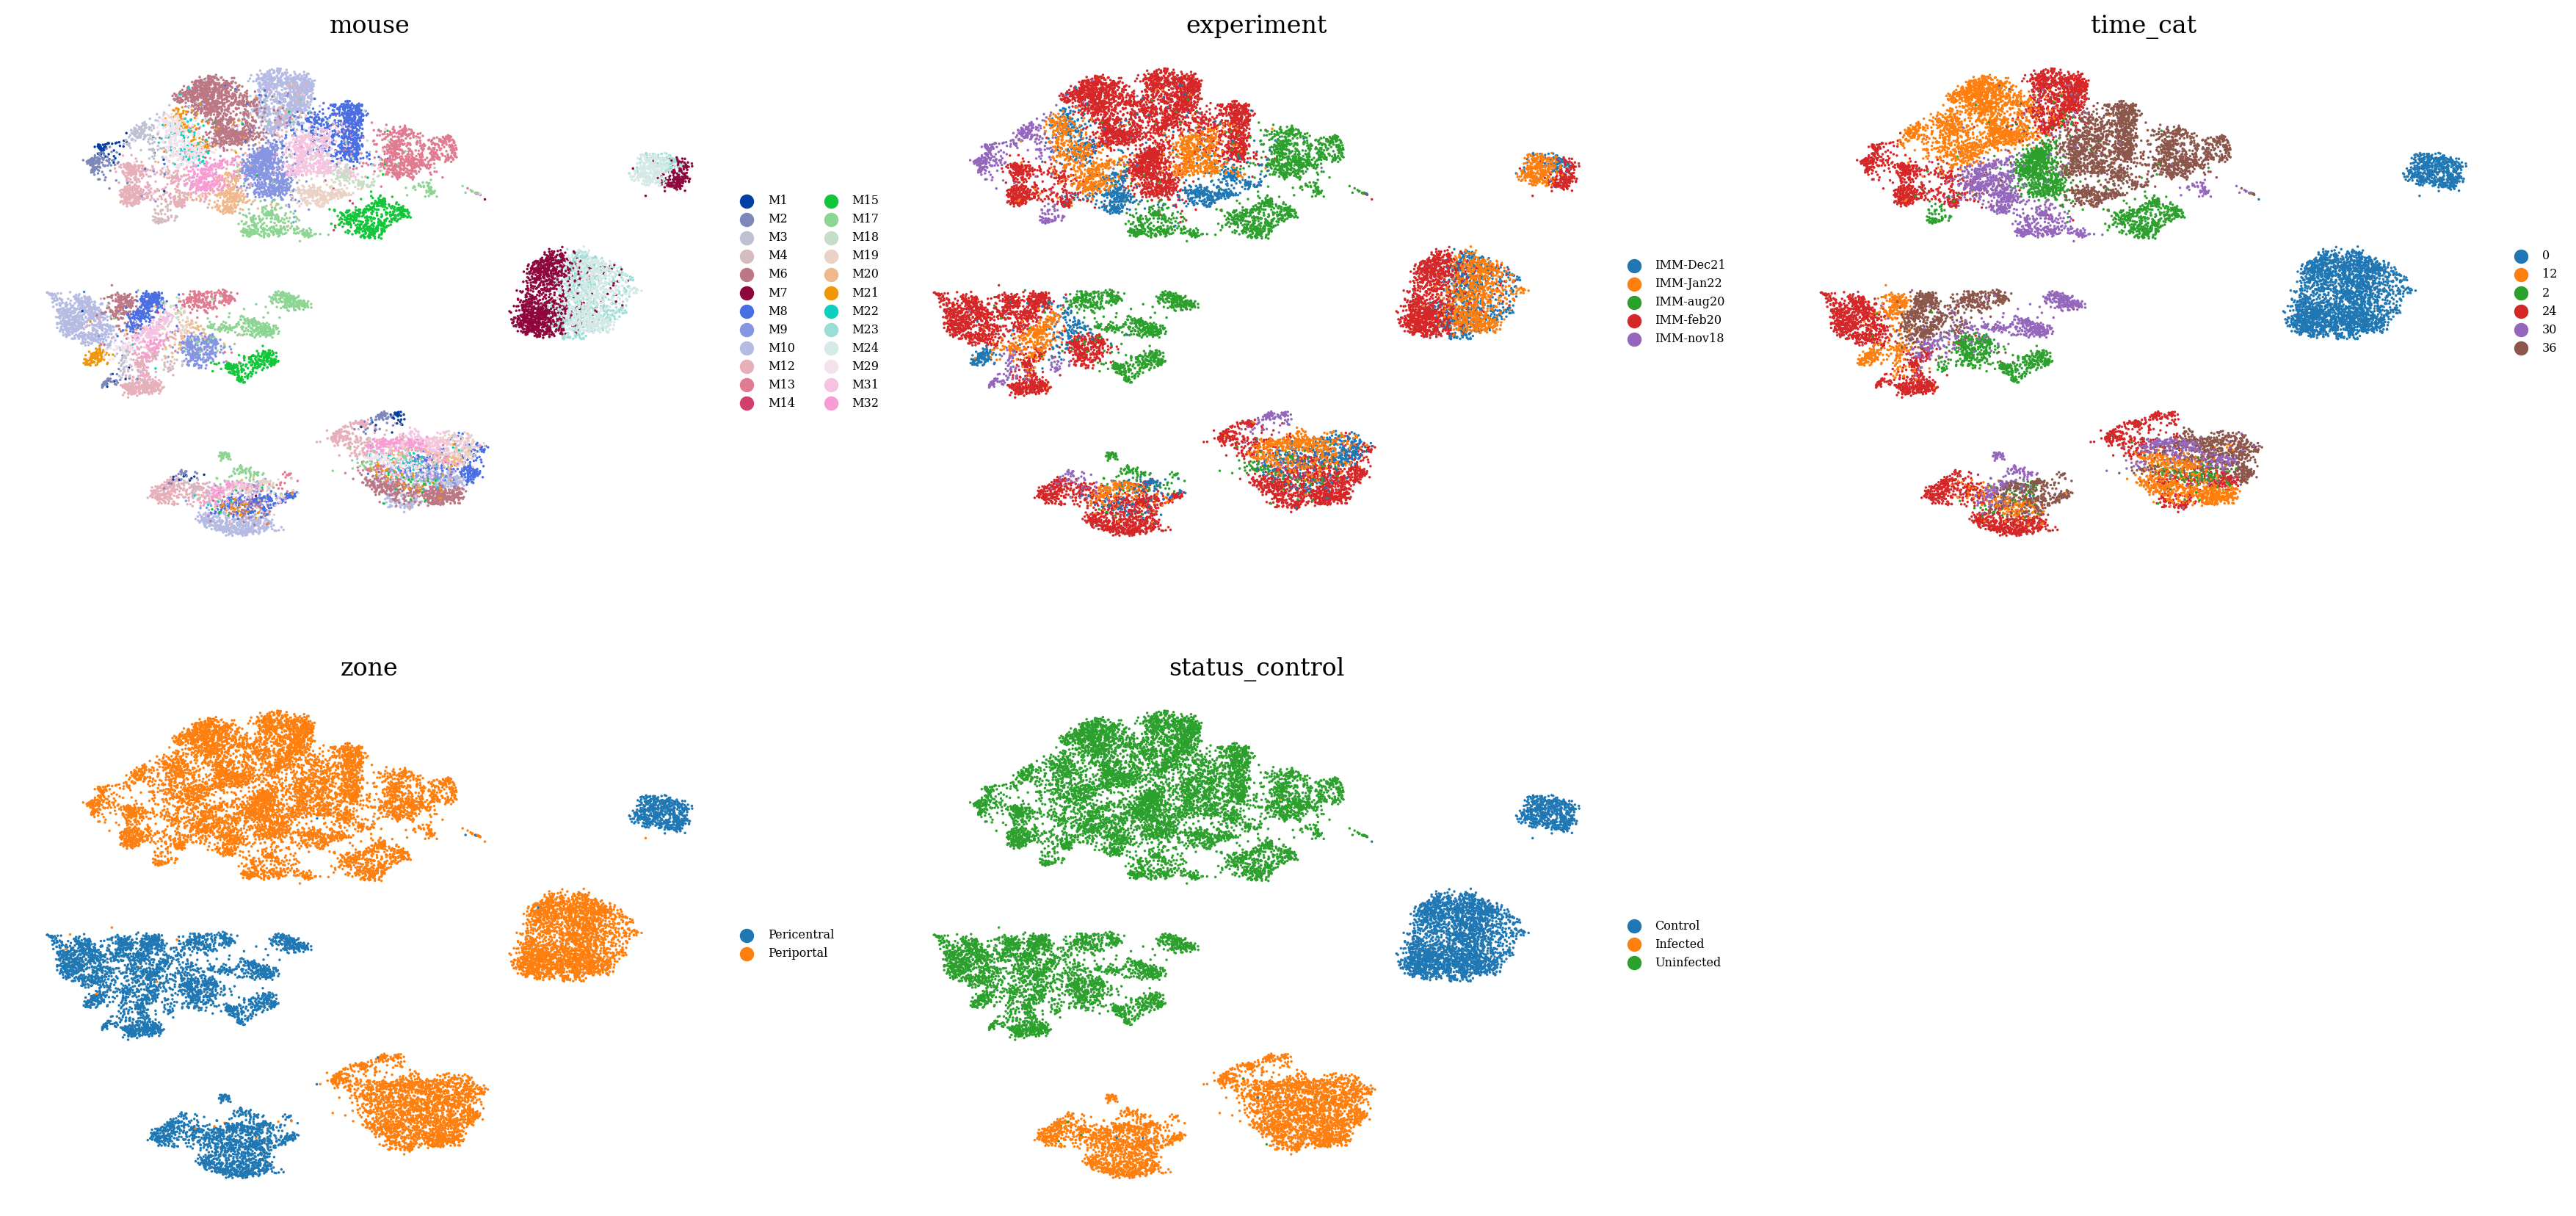

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

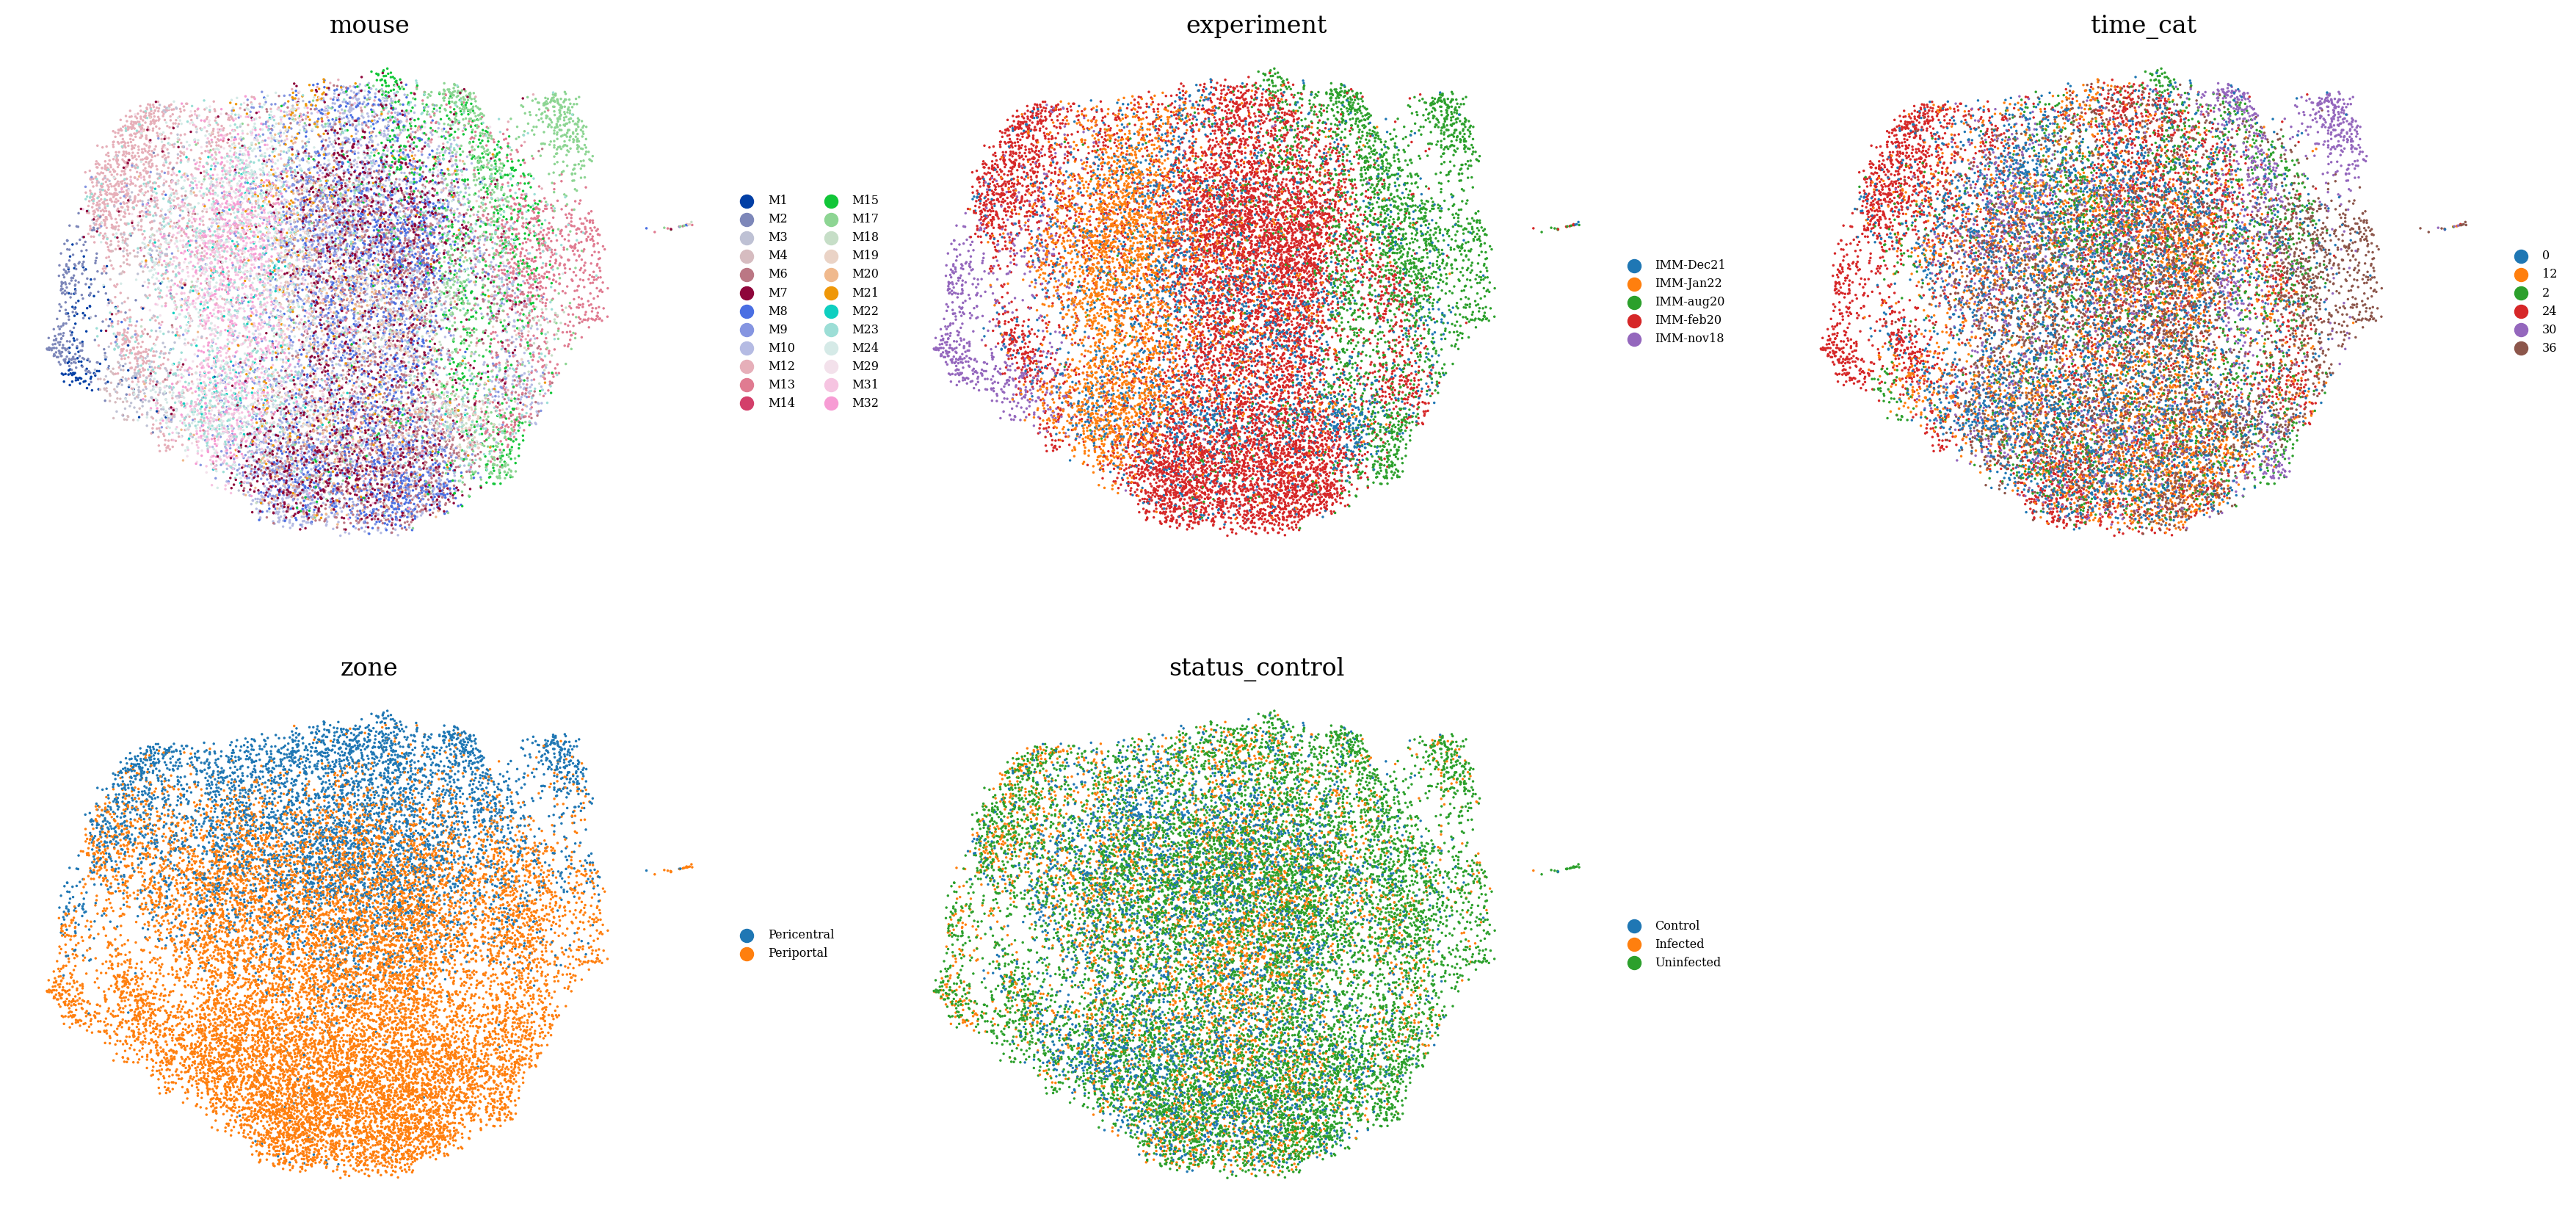

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  4%|▍         | 26/596 [00:00<00:02, 257.91it/s]

  9%|▉         | 54/596 [00:00<00:02, 266.57it/s]

 14%|█▎        | 81/596 [00:00<00:01, 264.94it/s]

 18%|█▊        | 108/596 [00:00<00:01, 263.00it/s]

 23%|██▎       | 135/596 [00:00<00:01, 262.80it/s]

 27%|██▋       | 162/596 [00:00<00:01, 262.62it/s]

 32%|███▏      | 189/596 [00:00<00:01, 262.12it/s]

 36%|███▌      | 216/596 [00:00<00:01, 261.77it/s]

 41%|████      | 243/596 [00:00<00:01, 261.87it/s]

 45%|████▌     | 270/596 [00:01<00:01, 261.92it/s]

 50%|████▉     | 297/596 [00:01<00:01, 262.07it/s]

 54%|█████▍    | 324/596 [00:01<00:01, 261.88it/s]

 59%|█████▉    | 351/596 [00:01<00:00, 261.85it/s]

 63%|██████▎   | 378/596 [00:01<00:00, 261.97it/s]

 68%|██████▊   | 405/596 [00:01<00:00, 262.25it/s]

 72%|███████▏  | 432/596 [00:01<00:00, 261.90it/s]

 77%|███████▋  | 459/596 [00:01<00:00, 262.14it/s]

 82%|████████▏ | 486/596 [00:01<00:00, 262.18it/s]

 86%|████████▌ | 513/596 [00:01<00:00, 262.56it/s]

 91%|█████████ | 540/596 [00:02<00:00, 263.40it/s]

 95%|█████████▌| 567/596 [00:02<00:00, 263.50it/s]

100%|█████████▉| 594/596 [00:02<00:00, 263.47it/s]

100%|██████████| 596/596 [00:02<00:00, 262.28it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

In [23]:
np.mean(r2s)

0.9725781389161983

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)